In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [20]:
training_set = pd.read_csv('datasets/train.csv')
test_set = pd.read_csv('datasets/test.csv')

In [21]:
training_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: xlabel='Survived', ylabel='count'>

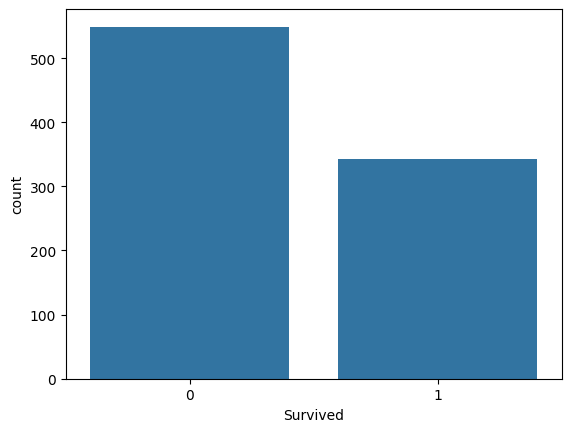

In [22]:
sns.countplot(x='Survived', data=training_set)

<Axes: xlabel='Age', ylabel='Survived'>

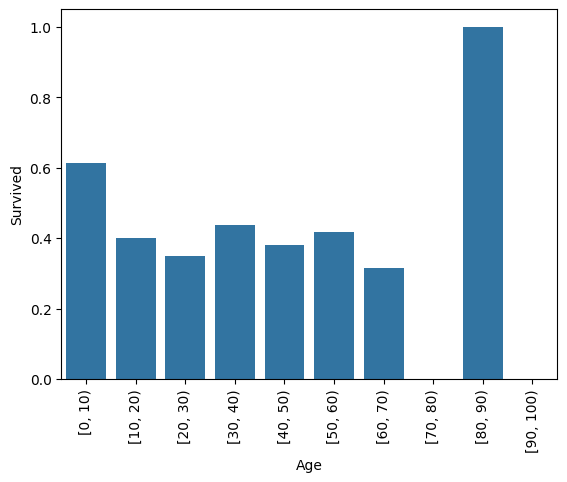

In [23]:
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cut_ages = pd.cut(training_set['Age'], bins=age_bins, right=False)
plt.xticks(rotation=90)
sns.barplot(x=cut_ages, y='Survived', data=training_set, errorbar=None)

<Axes: xlabel='Pclass', ylabel='Survived'>

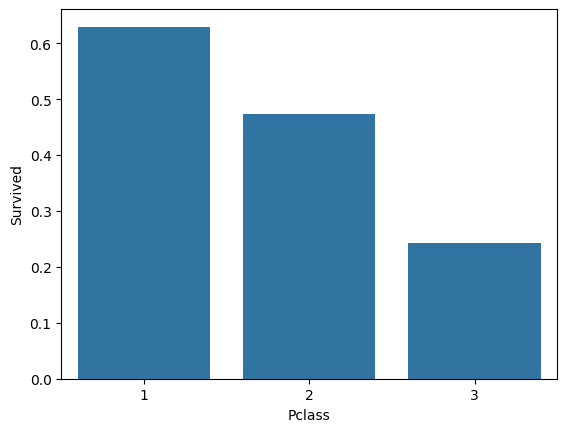

In [24]:
sns.barplot(x='Pclass', y='Survived', data=training_set, errorbar=None)

In [25]:
training_set.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64

In [26]:
titles=training_set['Name'].map(lambda x: x.split(' ')[1][:-1])
titles.value_counts().sort_values(ascending=False)
training_set['Title'] = titles.map(lambda x: 0 if x in ['Mr', 'Mrs', 'Miss', 'Master'] else 1)
titles.value_counts()

Name
Mr             502
Miss           179
Mrs            121
Master          40
Dr               7
Rev              6
                 4
Planke           3
Impe             3
Mlle             2
Gordon           2
Major            2
Col              2
de               1
Don              1
Steen            1
Mulder           1
Pelsmaeker       1
Walle            1
Billiard         1
Ms               1
Carlo            1
Mme              1
Messemaeker      1
Capt             1
Velde            1
th               1
Shawah           1
Jonkheer         1
Melkebeke        1
Cruyssen         1
Name: count, dtype: int64

In [27]:
df_train, df_test = train_test_split(training_set, train_size=0.8)

## 训练环节

In [28]:
def rmse(y1,y2):
    mse = mean_squared_error(y1, y2)
    return np.sqrt(mse)

In [29]:
# Train 1
clf=RandomForestClassifier(max_depth=10, n_estimators=100)
def train_1():
    features = ['Age', 'Sex', 'Pclass']
    X = pd.get_dummies(df_train[features])
    y=df_train['Survived']
    clf.fit(X, y)

    X_test= pd.get_dummies(df_test[features])
    result = clf.predict(X_test)
    print("RMSE:", rmse(df_test['Survived'], result))

In [30]:
# Train 2 with Title feature
from collections import defaultdict

def train_2(clf):
    features = ['Age', 'Sex', 'Pclass','Title']
    X = pd.get_dummies(df_train[features])
    y_train=df_train['Survived']
    y_test=df_test['Survived']
    clf.fit(X, y)

    X_test= pd.get_dummies(df_test[features])
    result = clf.predict(X_test)

def calc_best_classifier_params():
    depth_error = defaultdict(list)
    for i in range(5,20,5):
        for j in range(5,100,5):
            for _ in range(0,5):
                clf=RandomForestClassifier(max_depth=i, n_estimators=j)
                train_2(clf)            
                rmse_result=rmse(y_test, result)
                depth_error[(i,j)].append(rmse_result)

    mean_and_std_dev={}
    for key in depth_error:
        mean= np.mean(depth_error[key])
        std_dev= np.std(depth_error[key])
        mean_and_std_dev[key] = (mean, std_dev)

    return mean_and_std_dev


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_rmse_heatmap(mean_and_std_dev):
    # 准备数据
    depths = sorted(set(k[0] for k in mean_and_std_dev.keys()))
    estimators = sorted(set(k[1] for k in mean_and_std_dev.keys()))

    # 创建DataFrame存储结果
    mean_df = pd.DataFrame(index=depths, columns=estimators)
    std_df = pd.DataFrame(index=depths, columns=estimators)

    for (depth, est), (mean, std) in mean_and_std_dev.items():
        mean_df.loc[depth, est] = mean
        std_df.loc[depth, est] = std

    # 转换数据类型
    mean_df = mean_df.astype(float)
    std_df = std_df.astype(float)

    # 创建画布
    plt.figure(figsize=(18, 6))

    # 第一个子图 - 均值热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(mean_df, 
                annot=True, 
                fmt=".3f", 
                cmap="YlGnBu_r",  # 反转颜色，使低值更好看
                cbar_kws={'label': 'Mean RMSE'},
                linewidths=0.5)
    plt.title("Mean RMSE by Hyperparameters")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Max Depth")

    # 第二个子图 - 标准差热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(std_df, 
                annot=True, 
                fmt=".3f", 
                cmap="YlOrRd",  # 黄色到红色渐变
                cbar_kws={'label': 'Standard Deviation'},
                linewidths=0.5)
    plt.title("RMSE Standard Deviation by Hyperparameters")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Max Depth")

    plt.tight_layout()
    plt.show()

根据上图可以决定随机森林的两个参数，之后深度使用10，estimator使用100

In [32]:
features = ['Age', 'Sex', 'Pclass']
X_test=pd.get_dummies(test_set[features])
result = clf.predict(X_test)
# to csv
print(test_set['PassengerId'])
print(result)
submission = pd.DataFrame({'PassengerId': test_set['PassengerId'], 'Survived': result})
submission.to_csv('submission.csv', index=False)


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.